# Download Dataset

In [4]:
! git clone https://github.com/Akshay090/pokemon-image-dataset


fatal: destination path 'pokemon-image-dataset' already exists and is not an empty directory.


# Initial Setings and Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline    

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [10]:
from pathlib import Path
dataset_path = Path.cwd() / 'pokemon-image-dataset'
dataset_path

PosixPath('/content/pokemon-image-dataset')

In [11]:
for currentFile in dataset_path.iterdir():
    print(currentFile)

/content/pokemon-image-dataset/.git
/content/pokemon-image-dataset/charmander
/content/pokemon-image-dataset/bulbasaur
/content/pokemon-image-dataset/squirtle
/content/pokemon-image-dataset/pikachu


In [0]:
classes = ['pikachu','charmander','squirtle','bulbasaur']

In [0]:
for c in classes:
    print(c)
    verify_images(dataset_path/c, delete=True, max_size=500)

pikachu


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


charmander


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images wit

squirtle


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transp

bulbasaur


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transp

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path=dataset_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [13]:
data.classes

['bulbasaur', 'charmander', 'pikachu', 'squirtle']

In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bulbasaur', 'charmander', 'pikachu', 'squirtle'], 4, 484, 121)

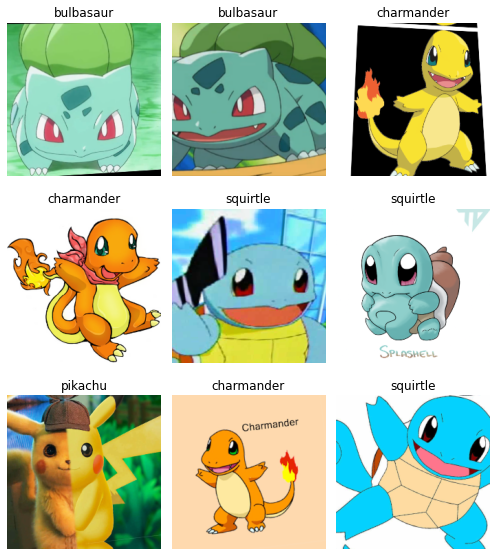

In [15]:
data.show_batch(rows=3, figsize=(7,8))

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.554398,0.156279,0.041322,00:20
1,0.769511,0.072930,0.008264,00:20
2,0.486908,0.079240,0.016529,00:20
3,0.347035,0.082099,0.016529,00:20


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


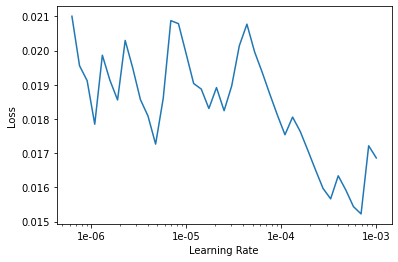

In [26]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.019142,0.114508,0.033058,00:20
1,0.015908,0.073927,0.016529,00:20


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

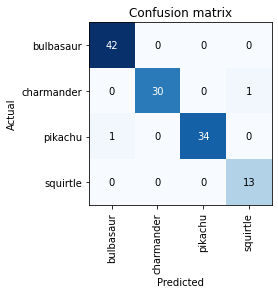

In [37]:
interp.plot_confusion_matrix()

In [40]:
interp.most_confused(min_val=1)

[('charmander', 'squirtle', 1), ('pikachu', 'bulbasaur', 1)]

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

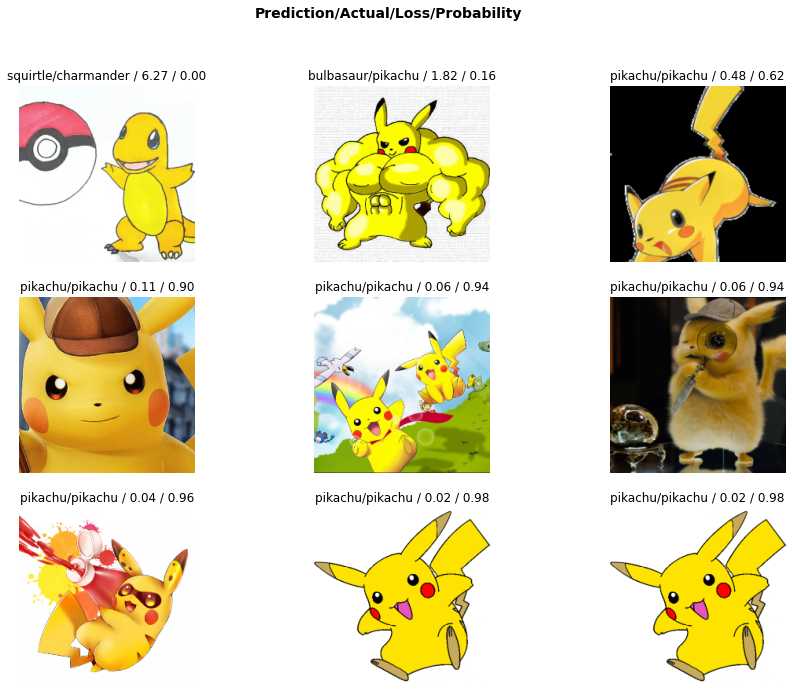

In [34]:
interp.plot_top_losses(9, figsize=(15,11))

## Putting your model in production

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [0]:
defaults.device = torch.device('cpu')

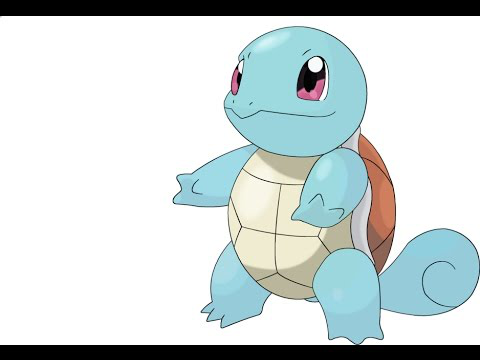

In [57]:
img = open_image(dataset_path/'squirtle/00000004.jpg')
img

In [0]:
learn = load_learner(dataset_path)

In [58]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category squirtle